In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
from mpl_toolkits.axes_grid1 import ImageGrid,make_axes_locatable,host_subplot
from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import sys
import os
import pyPIPS.utils as utils
import pyPIPS.thermolib as thermo
import pyPIPS.DSDlib as dsd
#import pyPIPS.disdrometer_module as dis
import pyPIPS.plotmodule as PIPSplot
import pyPIPS.simulator as sim
import pyPIPS.pips_io as pipsio
import pyPIPS.PIPS as pips
import pyPIPS.parsivel_params as pp
import pyPIPS.parsivel_qc as pqc
from pyCRMtools.modules import plotmodule as plotmod
from pyCRMtools.modules import utils as CRMutils
from pyCRMtools.pycaps import arps_read
from pyCRMtools.pycaps import pycaps_fields
from pyCRMtools.pycaps import calvars_radar as radar
import pandas as pd
import xarray as xr
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from scipy import ndimage
from metpy.plots import StationPlot
from metpy.calc import wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:


In [2]:
# Define dictionaries, keyed by case date (i.e. '060509', '060709', '060909', '033116'), to store parameters related
# to NEXRAD radar data, disdrometer data, and model output, respectively

# Case we are looking at right now. Should only have to change this up here and then execute all the cells below
# to generate the appropriate analysis
casedate = '033116'

# Import the file containing the dictionaries needed to gather the radar, disdrometer, and model data.
sys.path.append('/Users/dawson29/Dropbox/Projects/VORTEXSE/vortexse_enkf_dsd_study/configs/2016_IOP3')

from PIPSsim_1km_dicts import *

In [3]:
# Read in the PIPS data for the first probe for testing
dis_dict = init_dis_dict[casedate]
dirname = dis_dict['dis_dir']
filename = dis_dict['disfilenames'][0]
filepath = os.path.join(dirname, filename)
print("Reading file: {}".format(filepath))
conv_df, parsivel_df, vd_matrix_da = pipsio.read_PIPS(filepath)

Reading file: /Users/ddawson/Dropbox/Projects/VORTEXSE/obs_data/PIPS/2016/IOP3/PIPS_1A_IOP_3_D1.txt
GPS time: Thu Mar 31 22:12:03 2016, Logger time: Thu Mar 31 22:12:00 2016
GPS Offset: 0:00:03


In [4]:
print(vd_matrix_da)
#print(spectrum_da.loc['2016-03-31T22:30'])
diameter_bins = pp.parsivel_parameters['avg_diameter_bins_mm']
# print(diameter_bins)
fallspeed_bins = pp.parsivel_parameters['avg_fallspeed_bins_mps']
# print(fallspeed_bins)

empirical_fallspeed = pips.calc_empirical_fallspeed(diameter_bins)
# print(empirical_fallspeed)

fallspeed_spectrum1 = pips.calc_fallspeed_spectrum(diameter_bins, fallspeed_bins, use_measured_fallspeed=False)
#print(fallspeed_spectrum1)
fallspeed_spectrum2 = pips.calc_fallspeed_spectrum(diameter_bins, fallspeed_bins, use_measured_fallspeed=True)
#print(fallspeed_spectrum2)

<xarray.DataArray (time: 380, fallspeed_bin: 32, diameter_bin: 32)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
 

In [5]:
conv_df = pips.calc_thermo(conv_df)

DSD_interval = 10.
PSD_datetimes = pips.get_PSD_datetimes(vd_matrix_da)
PSD_datetimes_dict = pips.get_PSD_time_bins(PSD_datetimes)
PSDstarttimes = PSD_datetimes_dict['PSD_datetimes_edges']
PSDmidtimes = PSD_datetimes_dict['PSD_datetimes']

sec_offset = PSD_datetimes[0].second
conv_resampled_df = pips.resample_conv('PIPS', DSD_interval, sec_offset, conv_df)
conv_resampled_df_index = conv_resampled_df.index.intersection(parsivel_df.index)
conv_resampled_df = conv_resampled_df.loc[conv_resampled_df_index]

print(parsivel_df.columns)
#print(conv_resampled_df)

#parsivel_resampled_df = pips.resample_parsivel(60., parsivel_df)
resample_interval = 60.
intervalstr = '{:d}S'.format(int(resample_interval))
parsivel_resampler = parsivel_df.resample(intervalstr, label='right', closed='right',
                                          base=sec_offset)

parsivel_resampled_df = parsivel_resampler.agg({'precipintensity': np.mean, 'precipaccum': np.sum,
                                   'parsivel_dBZ': np.mean, 'pcount': np.sum,
                                   'signal_amplitude': np.mean, 'pvoltage': np.mean, 'sensor_temp': np.mean,
                                   'sample_interval': np.mean})

print(parsivel_resampled_df.columns)


# for time in vd_matrix_da['time'].to_index():
#     print(parsivel_df['pcount'].loc[time])
#     # print(conv_resampled_df['rho'].loc[time])
#     # print(vd_matrix_da.loc[time])

Index(['parsivel_dBZ', 'pcount', 'precipaccum', 'precipintensity', 'pvoltage',
       'sample_interval', 'sensor_temp', 'signal_amplitude'],
      dtype='object')
Index(['precipintensity', 'precipaccum', 'parsivel_dBZ', 'pcount',
       'signal_amplitude', 'pvoltage', 'sensor_temp', 'sample_interval'],
      dtype='object')


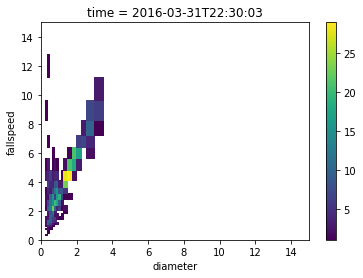

In [6]:
vd = vd_matrix_da.loc['2016-03-31T22:30:03']
vd['diameter'] = ('diameter_bin', diameter_bins)
vd['fallspeed'] = ('fallspeed_bin', fallspeed_bins)
vd.where(vd > 0.0).plot(x='diameter', y='fallspeed', xlim=[0., 15], ylim=[0., 15.])

Severe Wind contamination, masking entire PSD!
Severe Wind contamination, masking entire PSD!
Severe Wind contamination, masking entire PSD!
Severe Wind contamination, masking entire PSD!
380


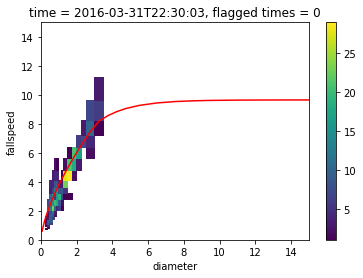

In [7]:
# Do some QC
vd_matrix_QC = pqc.strongwindQC(vd_matrix_da)
vd_matrix_QC = pqc.rainonlyQC(vd_matrix_QC)
vdQC = vd_matrix_QC.loc['2016-03-31T22:30:03']
vdQC['diameter'] = ('diameter_bin', diameter_bins)
vdQC['fallspeed'] = ('fallspeed_bin', fallspeed_bins)
vdQC.where(vdQC > 0.0).plot(x='diameter', y='fallspeed', xlim=[0., 15], ylim=[0., 15.])
plt.plot(diameter_bins, empirical_fallspeed, color='r')

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:601: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


<xarray.DataArray (time: 380, diameter_bin: 32)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time           (time) datetime64[ns] 2016-03-31T22:11:53 ... 2016-03-31T23:15:03
    diameter       (diameter_bin) float64 0.0625 0.1875 0.3125 ... 21.5 24.5
    min_diameter   (diameter_bin) float64 0.0 0.125 0.25 ... 18.0 20.0 23.0
    max_diameter   (diameter_bin) float64 0.125 0.25 0.375 ... 20.0 23.0 26.0
    flagged times  (time) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Dimensions without coordinates: diameter_bin


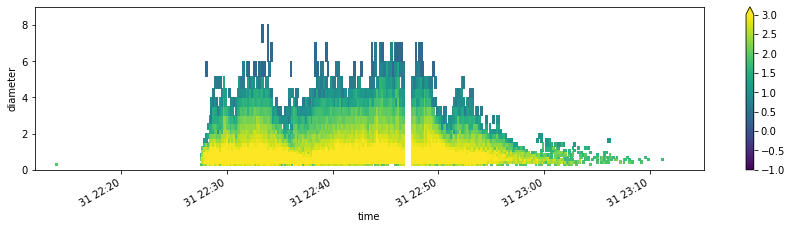

In [8]:
# Calculate ND
ND1 = pips.calc_ND(vd_matrix_QC.where(vd_matrix_QC > 0.0), fallspeed_spectrum1, 10.)
ND2 = pips.calc_ND(vd_matrix_QC.where(vd_matrix_QC > 0.0), fallspeed_spectrum2, 10.)
np.log10(ND1).T.plot(y='diameter', ylim=[0.0, 9.0], vmin=-1.0, vmax=3.0, aspect=5, size=3)
print(ND1)

In [9]:
timelimits = [PSDstarttimes[0], PSDstarttimes[-1]]
diamlimits = [0.0, 9.0]
diamytick = 1.0
DSDtype = 'observed'
locator = dates.MinuteLocator(byminute=[0, 15, 30, 45])
minorlocator = dates.MinuteLocator(byminute=range(0, 60, 5))
dateformat = '%H:%M'
formatter = dates.DateFormatter(dateformat)

axparams = {'majorxlocator': locator, 'majorxformatter': formatter,
            'minorxlocator': minorlocator,
            'axeslimits': [timelimits, diamlimits],
            'majorylocator': ticker.MultipleLocator(base=diamytick),
            'axeslabels': [None, 'D (mm)']}

disvars = {
    'min_diameter': ND2['min_diameter'], 
    'PSDstarttimes': PSDstarttimes,
    'PSDmidtimes': PSDmidtimes, 
    'logND': np.log10(ND2).T
}
dis_plot_name = 'PIPS1A'
PIPSplot.plotDSDmeteograms(dis_plot_name, './', axparams, disvars)

No handles with labels found to put in legend.


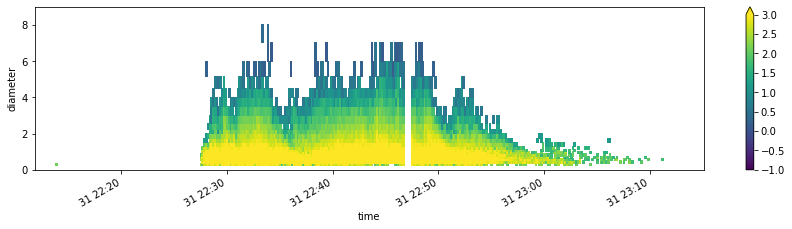

In [10]:
np.log10(ND2).T.plot(y='diameter', ylim=[0.0, 9.0], vmin=-1.0, vmax=3.0, aspect=5, size=3)

In [11]:
# Now resample the vd matrix across time to go from 10-s to 60-s intervals
resample_interval = pips.check_requested_resampling_interval(60., 10.)
vd_matrix_rs = pips.resample_vd_matrix(resample_interval, vd_matrix_QC)
print(vd_matrix_QC['time'][:10])
print(vd_matrix_rs['time'][:10])

Requested DSD interval: 60.0. Actual DSD interval: 60.0
<xarray.DataArray 'time' (time: 10)>
array(['2016-03-31T22:11:53.000000000', '2016-03-31T22:12:03.000000000',
       '2016-03-31T22:12:13.000000000', '2016-03-31T22:12:23.000000000',
       '2016-03-31T22:12:33.000000000', '2016-03-31T22:12:43.000000000',
       '2016-03-31T22:12:53.000000000', '2016-03-31T22:13:03.000000000',
       '2016-03-31T22:13:13.000000000', '2016-03-31T22:13:23.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time           (time) datetime64[ns] 2016-03-31T22:11:53 ... 2016-03-31T22:13:23
    flagged times  (time) int64 0 0 0 0 0 0 0 0 0 0
<xarray.DataArray 'time' (time: 10)>
array(['2016-03-31T22:11:53.000000000', '2016-03-31T22:12:53.000000000',
       '2016-03-31T22:13:53.000000000', '2016-03-31T22:14:53.000000000',
       '2016-03-31T22:15:53.000000000', '2016-03-31T22:16:53.000000000',
       '2016-03-31T22:17:53.000000000', '2016-03-31T22:18:53.000000000',
       '2016-03-31T22:19:53.0000

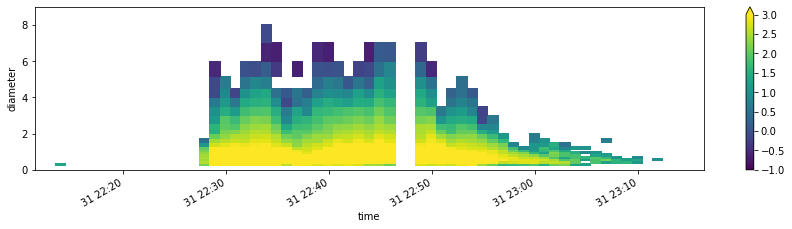

In [12]:
ND_resampled = pips.calc_ND(vd_matrix_rs.where(vd_matrix_rs > 0.0), fallspeed_spectrum2, 60.)
np.log10(ND_resampled).T.plot(y='diameter', ylim=[0.0, 9.0], vmin=-1.0, vmax=3.0, aspect=5, size=3)



In [13]:
# Add additional thermodynamic variables to conv_df
conv_df = pips.calc_thermo(conv_df)


Index(['GPS_alt', 'GPS_date', 'GPS_dir', 'GPS_lat', 'GPS_lon', 'GPS_magvar',
       'GPS_spd', 'GPS_status', 'GPS_time', 'RH', 'RH_derived', 'compass_dir',
       'dewpoint', 'fasttemp', 'pressure', 'slowtemp', 'voltage', 'winddiag',
       'winddirabs', 'winddirrel', 'windspd', 'pt', 'qv', 'rho'],
      dtype='object')


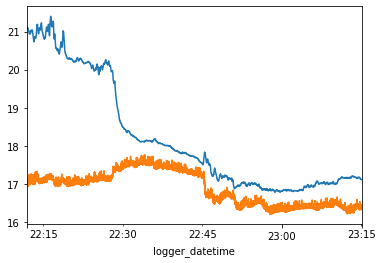

In [14]:
print(conv_df.columns)
conv_df['fasttemp'].plot()
conv_df['dewpoint'].plot()

In [15]:
# Resample conventional data to 60-s
datetime_range_onesec = conv_df.index.to_pydatetime()
sec_offset = pips.get_offset_seconds(datetime_range_onesec)
conv_rs_df = pips.resample_conv('PIPS', 60., sec_offset, conv_df)

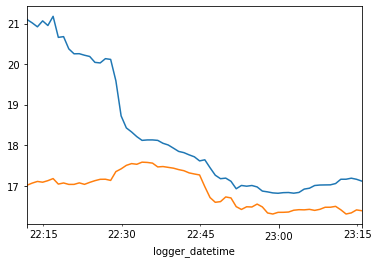

In [16]:
conv_rs_df['fasttemp'].plot()
conv_rs_df['dewpoint'].plot()

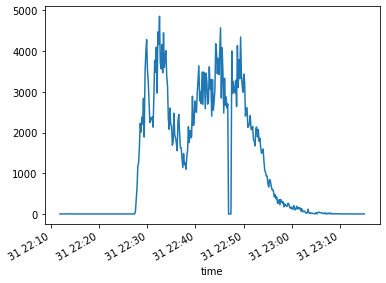

In [17]:
# Test calculation of moments
M0, M0_binned = dsd.calc_moment_bin(ND1, moment=0)
M0.plot()

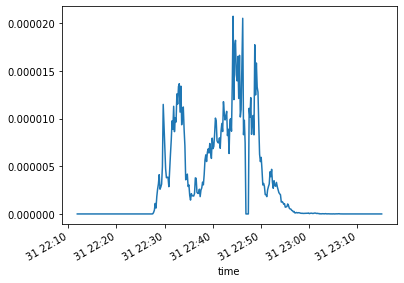

In [18]:
M3, M3_binned = dsd.calc_moment_bin(ND1, moment=3)
M3.plot()

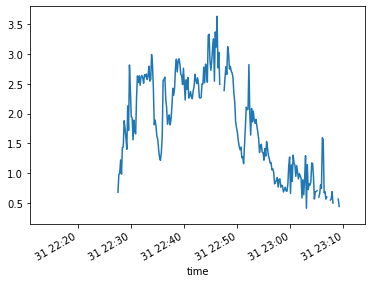

In [19]:
# Testing calculation of D0

D0 = dsd.calc_D0_bin(ND1) * 1000.
D0.plot()

In [ ]:
Dm = ND1['diameter'] / 1000.
M3, M3_binned = dsd.calc_moment_bin(ND1, moment=3)

M3_binned = M3_binned.where(M3_binned != 0.)
print(M3_binned.loc[dict(time='2016-03-31T22:30:00')])
M3_arr = M3_binned.loc[dict(time='2016-03-31T22:30:00')].values
print(M3_arr)
print()
M3_med = M3_binned.quantile(0.5, dim='diameter_bin', interpolation='linear')
print(M3_med.loc[dict(time='2016-03-31T22:30:00')])
# D0 is the cube root of this median volume
D0 = M3_med**(1./3.) * 1000.
print(D0.loc[dict(time='2016-03-31T22:30:00')])
D0.plot()

In [20]:
# Test interpolating from one index to another

da = xr.DataArray(np.sin(0.3 * np.arange(12).reshape(4, 3)),
                  [('time', np.arange(4)),
                   ('space', [0.1, 0.2, 0.3])])

other = xr.DataArray(np.sin(0.4 * np.arange(9).reshape(3, 3)),
                     [('time', [0.9, 1.9, 2.9]),
                      ('space', [0.1, 0.2, 0.3])])

In [21]:
print(da)
print(other)

<xarray.DataArray (time: 4, space: 3)>
array([[ 0.        ,  0.29552021,  0.56464247],
       [ 0.78332691,  0.93203909,  0.99749499],
       [ 0.97384763,  0.86320937,  0.67546318],
       [ 0.42737988,  0.14112001, -0.15774569]])
Coordinates:
  * time     (time) int64 0 1 2 3
  * space    (space) float64 0.1 0.2 0.3
<xarray.DataArray (time: 3, space: 3)>
array([[ 0.        ,  0.38941834,  0.71735609],
       [ 0.93203909,  0.9995736 ,  0.90929743],
       [ 0.67546318,  0.33498815, -0.05837414]])
Coordinates:
  * time     (time) float64 0.9 1.9 2.9
  * space    (space) float64 0.1 0.2 0.3


In [22]:
interpolated = da.interp_like(other)
interpolated


<xarray.DataArray (time: 3, space: 3)>
array([[ 0.70499422,  0.8683872 ,  0.95420974],
       [ 0.95479556,  0.87009234,  0.70766636],
       [ 0.48202666,  0.21332894, -0.07442481]])
Coordinates:
  * time     (time) float64 0.9 1.9 2.9
  * space    (space) float64 0.1 0.2 0.3

In [23]:
x0 = 0
y0 = 0
x1 = 1
y1 = 0.783327

x = 0.9

y = y0 + (x - x0) * (y1 - y0) / (x1 - x0)
print(y)


0.7049943


In [24]:
M2, _ = dsd.calc_moment_bin(ND_resampled, moment=2)
M3, _ = dsd.calc_moment_bin(ND_resampled, moment=3)
M4, _ = dsd.calc_moment_bin(ND_resampled, moment=4)
M6, _ = dsd.calc_moment_bin(ND_resampled, moment=6)

DSD_MM24 = dsd.fit_DSD_MM24(M2, M4)
DSD_MM36 = dsd.fit_DSD_MM36(M3, M6)
DSD_MM346 = dsd.fit_DSD_MM346(M3, M4, M6)
DSD_MM246 = dsd.fit_DSD_MM246(M2, M4, M6)
DSD_MM234 = dsd.fit_DSD_MM234(M2, M3, M4)

D_min, D_max = dsd.get_max_min_diameters(ND_resampled)
print(D_max)

DSD_TMM246 = dsd.fit_DSD_TMM_xr(M2, M4, M6, D_min, D_max)

<xarray.DataArray 'diameter' (time: 65)>
array([0.0245   , 0.0245   , 0.0003125, 0.0245   , 0.0245   , 0.0245   ,
       0.0245   , 0.0245   , 0.0245   , 0.0245   , 0.0245   , 0.0245   ,
       0.0245   , 0.0245   , 0.0245   , 0.0245   , 0.001625 , 0.0055   ,
       0.00475  , 0.00425  , 0.0055   , 0.0055   , 0.0075   , 0.0065   ,
       0.00425  , 0.0055   , 0.00425  , 0.0065   , 0.0065   , 0.0055   ,
       0.00475  , 0.0055   , 0.0065   , 0.0065   , 0.0065   , 0.0245   ,
       0.0245   , 0.0065   , 0.0055   , 0.00325  , 0.00425  , 0.00475  ,
       0.00425  , 0.00325  , 0.00275  , 0.001875 , 0.001375 , 0.0011875,
       0.001875 , 0.001625 , 0.001375 , 0.001375 , 0.0011875, 0.0011875,
       0.0009375, 0.001625 , 0.0006875, 0.0005625, 0.0006875, 0.0245   ,
       0.0005625, 0.0245   , 0.0245   , 0.0245   , 0.0245   ])
Coordinates:
    diameter      (time) float64 24.5 24.5 0.3125 24.5 ... 24.5 24.5 24.5 24.5
    min_diameter  (time) float64 23.0 23.0 0.25 23.0 ... 23.0 23.0 23.0 23

/Users/dawson29/Projects/pyPIPS/pyPIPS/DSDlib.py:985: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fit_DSD_TMM" failed type inference due to: Untyped global name 'fit_DSD_MM246': cannot determine Numba type of <class 'function'>

File "../pyPIPS/DSDlib.py", line 1013:
def fit_DSD_TMM(M2, M4, M6, D_min, D_max):
    <source elided>
    # Get initial estimate of lamda and mu from the untruncated fit:
    _, lamda_init, mu_init = fit_DSD_MM246(M2, M4, M6)
    ^

  @jit
/Users/dawson29/Projects/pyPIPS/pyPIPS/DSDlib.py:985: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "fit_DSD_TMM" failed type inference due to: Untyped global name 'fit_DSD_MM246': cannot determine Numba type of <class 'function'>

File "../pyPIPS/DSDlib.py", line 1013:
def fit_DSD_TMM(M2, M4, M6, D_min, D_max):
    <source elided>
    # Get initial estimate of lamda and mu from the untruncated fit:
    _, lamda_i

Working on time 0
Working on time 1
Working on time 2
Working on time 3
Working on time 4
Working on time 5
Working on time 6
Working on time 7
Working on time 8
Working on time 9
Working on time 10
Working on time 11
Working on time 12
Working on time 13
Working on time 14
Working on time 15
Working on time 16
Working on time 17
Working on time 18
Working on time 19
Working on time 20
Working on time 21
Working on time 22
Working on time 23
Working on time 24
Working on time 25


/Users/dawson29/Projects/pyPIPS/pyPIPS/DSDlib.py:976: RuntimeWarning: overflow encountered in exp
  N0, lamda, alpha = fit_DSD_TMM(M2_arr, M4_arr, M6_arr, D_min_arr, D_max_arr)
/Users/dawson29/Projects/pyPIPS/pyPIPS/DSDlib.py:976: RuntimeWarning: invalid value encountered in double_scalars
  N0, lamda, alpha = fit_DSD_TMM(M2_arr, M4_arr, M6_arr, D_min_arr, D_max_arr)


Working on time 26
Working on time 27
Working on time 28
Working on time 29
Working on time 30
Working on time 31
Working on time 32
Working on time 33
Working on time 34
Working on time 35
Working on time 36
Working on time 37
Working on time 38
Working on time 39
Working on time 40
Working on time 41
Working on time 42
Working on time 43
Working on time 44
Working on time 45
Working on time 46
Working on time 47
Working on time 48
Working on time 49
Working on time 50
Working on time 51
Working on time 52
Working on time 53
Working on time 54
Working on time 55
Working on time 56
Working on time 57
Working on time 58
Working on time 59
Working on time 60
Working on time 61
Working on time 62
Working on time 63
Working on time 64


In [25]:
ND_MM24 = dsd.calc_binned_DSD_from_params(*DSD_MM24, ND_resampled['diameter'])
ND_MM36 = dsd.calc_binned_DSD_from_params(*DSD_MM36, ND_resampled['diameter'])
ND_MM234 = dsd.calc_binned_DSD_from_params(*DSD_MM234, ND_resampled['diameter'])
ND_MM246 = dsd.calc_binned_DSD_from_params(*DSD_MM246, ND_resampled['diameter'])
ND_MM346 = dsd.calc_binned_DSD_from_params(*DSD_MM346, ND_resampled['diameter'])
ND_TMM246 = dsd.calc_binned_DSD_from_params(*DSD_TMM246, ND_resampled['diameter'])

<xarray.DataArray 'diameter' (diameter_bin: 32)>
array([6.2500e-05, 1.8750e-04, 3.1250e-04, 4.3750e-04, 5.6250e-04,
       6.8750e-04, 8.1250e-04, 9.3750e-04, 1.0625e-03, 1.1875e-03,
       1.3750e-03, 1.6250e-03, 1.8750e-03, 2.1250e-03, 2.3750e-03,
       2.7500e-03, 3.2500e-03, 3.7500e-03, 4.2500e-03, 4.7500e-03,
       5.5000e-03, 6.5000e-03, 7.5000e-03, 8.5000e-03, 9.5000e-03,
       1.1000e-02, 1.3000e-02, 1.5000e-02, 1.7000e-02, 1.9000e-02,
       2.1500e-02, 2.4500e-02])
Coordinates:
    diameter      (diameter_bin) float64 0.0625 0.1875 0.3125 ... 19.0 21.5 24.5
    min_diameter  (diameter_bin) float64 0.0 0.125 0.25 0.375 ... 18.0 20.0 23.0
    max_diameter  (diameter_bin) float64 0.125 0.25 0.375 0.5 ... 20.0 23.0 26.0
Dimensions without coordinates: diameter_bin
<xarray.DataArray (time: 65)>
array([              nan,               nan,   187595.32782807,
                     nan,               nan,               nan,
                     nan,               nan,              

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:601: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


In [26]:
# Test plotting of individual DSD
time_to_plot = '2016-03-31T22:31:53'

axdict = {
    'xbin_left': ND_resampled['min_diameter'],
    'xbin_mid': ND_resampled['diameter'], 
    'xbin_right': ND_resampled['max_diameter'],
    'xlim': (0.0, 9.0), 
    'ylim': (10.**2., 10.**8.5), 
    'interval': int(resample_interval),
    'dis_name': 'PIPS_1A'
}

#print(ND_resampled['time'])

PSDdict = {
    'ND': ND_resampled.loc[time_to_plot]
}

PSDfitdict = {
    #'Exponential_24': (ND_MM24.loc[time_to_plot], 'Exp fit (MM24)'),
    #'Exponential_36': (ND_MM36.loc[time_to_plot], 'Exp fit (MM36)'),
    #'Gamma_234': (ND_MM234.loc[time_to_plot], 'Gamma fit (MM234)'),
    'Gamma_246': (ND_MM246.loc[time_to_plot], 'Gamma fit (MM246)'),
    #'Gamma_346': (ND_MM346.loc[time_to_plot], 'Gamma fit (MM346)')
    'TruncGamma_246': (ND_TMM246.loc[time_to_plot], 'Truncated Gamma fit (TMM246)'),
}

time_to_plot_datetime = pd.to_datetime(time_to_plot).to_pydatetime()

print(DSD_TMM246[0].loc[time_to_plot])

<xarray.DataArray ()>
array(536505.79616624)
Coordinates:
    time     datetime64[ns] 2016-03-31T22:31:53


Text(0, 0.5, 'N(D) $(m^{-4})$')

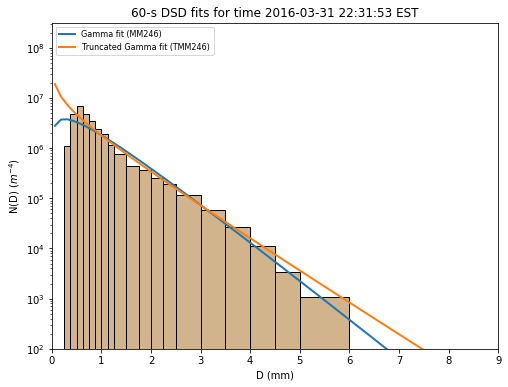

In [27]:
import pyPIPS.timemodule as tm
xbin_left = axdict.get('xbin_left', np.empty((0)))
xbin_right = axdict.get('xbin_right', np.empty((0)))
xbin_mid = axdict.get('xbin_mid', np.empty((0)))
ND = PSDdict.get('ND', np.empty((0)))
# ND_onedrop = PSDdict.get('ND_onedrop', N.empty((0)))
interval = axdict.get('interval', 10)
dis_name = axdict.get('dis_name', None)

fig1 = plt.figure(figsize=(8, 6))
ax1 = fig1.add_subplot(111)
plt.title('{0:d}-s DSD fits for time {1} EST'.format(interval, time_to_plot_datetime.strftime(tm.timefmt2)))
ax1.bar(xbin_left, ND * 1000.0, xbin_right - xbin_left, 10.**2., align='edge', log=True, color='tan', 
        edgecolor='k')

for fitname, ND_tuple in PSDfitdict.items():
    if ((fitname == 'Dis Retr') | (fitname == 'Rad Retr')):
        ND_fit = ND_tuple[0] * 1000.
    else:
        ND_fit = ND_tuple[0]
#         print ND_fit
    label = ND_tuple[1]
    if(ND_fit.size):
        ax1.plot(xbin_mid, ND_fit, lw=2, label=label)

plt.legend(loc='upper left', numpoints=1, ncol=1, fontsize=8)
        
ax1.set_yscale('log')
ax1.set_ylim(10.**2.0, 10.**8.5)
ax1.set_xlim(0.0, 9.0)
ax1.set_xlabel('D (mm)')
ax1.set_ylabel(r'N(D) $(m^{-4})$')


In [28]:
# Test merging of fit DataArrays to a Dataset

#print(DSD_MM24[0])

DSD_MM24[0].name = 'N0'
DSD_MM24[1].name = 'lamda'
# DSD_MM24[2].name = 'alpha'

DSD_MM24_da = xr.concat(DSD_MM24[:2], pd.Index(['N0', 'lamda'], name='parameter'))
DSD_MM24_da.name = 'DSD_MM24'
#print(DSD_MM24_da)

# DSD_MM24_ds = xr.merge(DSD_MM24[:2])

DSD_MM36[0].name = 'N0'
DSD_MM36[1].name = 'lamda'
DSD_MM36_da = xr.concat(DSD_MM36[:2], pd.Index(['N0', 'lamda'], name='parameter'))
DSD_MM36_da.name = 'DSD_MM36'
#print(DSD_MM36_da)

# DSD_MM36_ds = xr.merge(DSD_MM36[:2])

# fits_ds = xr.concat([DSD_MM24_da, DSD_MM36_da], dim='fit')

names = ['DSD_MM24', 'DSD_MM36']
data_arrays = [DSD_MM24_da, DSD_MM36_da]

fits_ds = xr.Dataset({name: da for name, da in zip(names, data_arrays)})
print(fits_ds)

# fits_ds = xr.merge([DSD_MM24, DSD_MM36, DSD_MM234, DSD_MM246, DSD_MM346, DSD_TMM246])
# print(fits_ds)


<xarray.Dataset>
Dimensions:    (parameter: 2, time: 65)
Coordinates:
  * time       (time) datetime64[ns] 2016-03-31T22:11:53 ... 2016-03-31T23:15:53
  * parameter  (parameter) object 'N0' 'lamda'
Data variables:
    DSD_MM24   (parameter, time) float64 nan nan 1.876e+05 nan ... nan nan nan
    DSD_MM36   (parameter, time) float64 nan nan 8.904e+05 nan ... nan nan nan


In [47]:
conv_df, parsivel_df, _ = pipsio.read_PIPS(filepath)
parsivel_ds = parsivel_df.to_xarray()

GPS time: Thu Mar 31 22:12:03 2016, Logger time: Thu Mar 31 22:12:00 2016
GPS Offset: 0:00:03
                     GPS_alt GPS_date  GPS_dir    GPS_lat    GPS_lon  \
time                                                                   
2016-03-31 22:11:53      NaN   310316      NaN  34.725167 -86.646333   
2016-03-31 22:11:54      NaN   310316      NaN  34.725167 -86.646333   
2016-03-31 22:11:55      NaN   310316      NaN  34.725167 -86.646333   
2016-03-31 22:11:56      NaN   310316      NaN  34.725167 -86.646333   
2016-03-31 22:11:57      NaN   310316      NaN  34.725167 -86.646333   
2016-03-31 22:11:58      NaN   310316      NaN  34.725167 -86.646333   
2016-03-31 22:11:59      NaN   310316      NaN  34.725167 -86.646333   
2016-03-31 22:12:00      NaN   310316      NaN  34.725167 -86.646333   
2016-03-31 22:12:01      NaN   310316      NaN  34.725167 -86.646333   
2016-03-31 22:12:02      NaN   310316      NaN  34.725167 -86.646333   
2016-03-31 22:12:03    250.5   310316     

In [48]:
# Test converting conventional data DataFrame to xarray

print(conv_df)
conv_ds = conv_df.to_xarray()
conv_ds


                     GPS_alt GPS_date  GPS_dir    GPS_lat    GPS_lon  \
time                                                                   
2016-03-31 22:11:53      NaN   310316      NaN  34.725167 -86.646333   
2016-03-31 22:11:54      NaN   310316      NaN  34.725167 -86.646333   
2016-03-31 22:11:55      NaN   310316      NaN  34.725167 -86.646333   
2016-03-31 22:11:56      NaN   310316      NaN  34.725167 -86.646333   
2016-03-31 22:11:57      NaN   310316      NaN  34.725167 -86.646333   
2016-03-31 22:11:58      NaN   310316      NaN  34.725167 -86.646333   
2016-03-31 22:11:59      NaN   310316      NaN  34.725167 -86.646333   
2016-03-31 22:12:00      NaN   310316      NaN  34.725167 -86.646333   
2016-03-31 22:12:01      NaN   310316      NaN  34.725167 -86.646333   
2016-03-31 22:12:02      NaN   310316      NaN  34.725167 -86.646333   
2016-03-31 22:12:03    250.5   310316      0.0  35.046500 -87.677500   
2016-03-31 22:12:04    250.9   310316      0.0  35.046500 -87.67

<xarray.Dataset>
Dimensions:      (time: 3791)
Coordinates:
  * time         (time) datetime64[ns] 2016-03-31T22:11:53 ... 2016-03-31T23:15:03
Data variables:
    GPS_alt      (time) float64 nan nan nan nan nan ... 253.6 253.5 253.4 253.4
    GPS_date     (time) object '310316' '310316' '310316' ... '310316' '310316'
    GPS_dir      (time) float64 nan nan nan nan nan ... 218.3 218.3 218.3 218.3
    GPS_lat      (time) float64 34.73 34.73 34.73 34.73 ... 35.05 35.05 35.05
    GPS_lon      (time) float64 -86.65 -86.65 -86.65 ... -87.68 -87.68 -87.68
    GPS_magvar   (time) float64 3.3 3.3 3.3 3.3 3.3 3.3 ... 2.6 2.6 2.6 2.6 2.6
    GPS_spd      (time) float64 nan nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    GPS_status   (time) object 'V' 'V' 'V' 'V' 'V' 'V' ... 'A' 'A' 'A' 'A' 'A'
    GPS_time     (time) object '221153' '221154' '221155' ... '231502' '231503'
    RH           (time) float64 75.0 75.17 74.96 75.13 ... 96.1 96.1 96.2 96.1
    RH_derived   (time) float64 77.52 77.7 77.1 77.94 ... 95.55 95.41 95.61
    compass_dir  (time) float64 47.5 47.4 47.4 47.4 47.5 ... 52.4 52.4 52.4 52.4
    dewpoint     (time) float64 17.02 17.06 16.95 17.12 ... 16.4 16.38 16.41
    fasttemp     (time) float64 21.1 21.11 21.12 21.12 ... 17.12 17.12 17.12
    pressure     (time) float64 974.0 974.0 974.0 974.0 ... 975.9 975.9 975.9
    slowtemp     (time) float64 21.64 21.65 21.58 21.72 ... 17.03 16.99 17.04
    voltage      (time) float64 12.98 12.98 12.96 12.96 ... 12.77 12.77 12.77
    winddiag     (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    winddirabs   (time) float64 114.5 177.4 105.4 68.4 ... 324.4 326.4 325.4
    winddirrel   (time) float64 67.0 130.0 58.0 21.0 ... 264.0 272.0 274.0 273.0
    windspd      (time) float64 0.34 0.97 0.38 0.65 0.81 ... 1.45 1.45 1.37 1.27

In [53]:
conv_ds = pipsio.conv_df_to_ds(conv_df)
print(conv_ds)
print(conv_ds['GPS_spd'])

<xarray.Dataset>
Dimensions:      (time: 3791)
Coordinates:
  * time         (time) datetime64[ns] 2016-03-31T22:11:53 ... 2016-03-31T23:15:03
Data variables:
    GPS_alt      (time) float64 nan nan nan nan nan ... 253.6 253.5 253.4 253.4
    GPS_date     (time) object '310316' '310316' '310316' ... '310316' '310316'
    GPS_dir      (time) float64 nan nan nan nan nan ... 218.3 218.3 218.3 218.3
    GPS_lat      (time) float64 34.73 34.73 34.73 34.73 ... 35.05 35.05 35.05
    GPS_lon      (time) float64 -86.65 -86.65 -86.65 ... -87.68 -87.68 -87.68
    GPS_magvar   (time) float64 3.3 3.3 3.3 3.3 3.3 3.3 ... 2.6 2.6 2.6 2.6 2.6
    GPS_spd      (time) float64 nan nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    GPS_status   (time) object 'V' 'V' 'V' 'V' 'V' 'V' ... 'A' 'A' 'A' 'A' 'A'
    GPS_time     (time) object '221153' '221154' '221155' ... '231502' '231503'
    RH           (time) float64 75.0 75.17 74.96 75.13 ... 96.1 96.1 96.2 96.1
    RH_derived   (time) float64 77.52 77.7 77.1

In [57]:
conv_nc_path = './conv_test.nc'
pipsio.dump_conv_netcdf(conv_nc_path, conv_ds)
conv_ds_from_netcdf.close()
conv_ds_from_netcdf = xr.open_dataset(conv_nc_path)
print(conv_ds_from_netcdf)
print(conv_ds_from_netcdf['time'])

PermissionError: [Errno 13] Permission denied: b'/Users/dawson29/Projects/pyPIPS/notebooks/conv_test.nc'

In [58]:
print(conv_ds_from_netcdf['GPS_time'])

<xarray.DataArray 'GPS_time' (time: 3791)>
array(['221153', '221154', '221155', ..., '231501', '231502', '231503'],
      dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 2016-03-31T22:11:53 ... 2016-03-31T23:15:03


In [104]:
_, parsivel_df, vd_matrix_da = pipsio.read_PIPS(filepath)
parsivel_ds = pipsio.parsivel_df_to_ds(parsivel_df)

GPS time: Thu Mar 31 22:12:03 2016, Logger time: Thu Mar 31 22:12:00 2016
GPS Offset: 0:00:03


In [107]:
parsivel_ds = pipsio.combine_parsivel_data(parsivel_ds, vd_matrix_da)
parsivel_ds

<xarray.Dataset>
Dimensions:                   (diameter_bin: 32, fallspeed_bin: 32, time: 380)
Coordinates:
  * time                      (time) datetime64[ns] 2016-03-31T22:11:53 ... 2016-03-31T23:15:03
    fallspeed                 (fallspeed_bin) float64 0.05 0.15 ... 17.6 20.8
    diameter                  (diameter_bin) float64 0.0625 0.1875 ... 21.5 24.5
    min_diameter              (diameter_bin) float64 0.0 0.125 ... 20.0 23.0
    max_diameter              (diameter_bin) float64 0.125 0.25 ... 23.0 26.0
    min_fallspeeds            (fallspeed_bin) float64 0.0 0.1 0.2 ... 16.0 19.2
    max_fallspeeds            (fallspeed_bin) float64 0.1 0.2 0.3 ... 19.2 22.4
Dimensions without coordinates: diameter_bin, fallspeed_bin
Data variables:
    parsivel_dBZ              (time) float64 -9.999 -9.999 ... -9.999 -9.999
    pcount                    (time) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    precipaccum               (time) float64 0.0 0.0 0.0 ... 36.83 36.83 36.83
    precipintensity           (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    pvoltage                  (time) float64 12.0 12.0 12.0 ... 11.8 11.8 11.8
    sample_interval           (time) float64 10.0 10.0 10.0 ... 10.0 10.0 10.0
    sensor_temp               (time) float64 -55.0 -55.0 -55.0 ... -55.0 -55.0
    signal_amplitude          (time) float64 2.152e+04 2.151e+04 ... 1.619e+04
    velocity-diameter matrix  (time, fallspeed_bin, diameter_bin) int64 0 ... 0
Attributes:
    nominal sample interval:  10 seconds